<h2 align="center">Predicting Employee Churn with Interactive Decision Trees and Random Forests</h2>

In this project, I use interactive decision trees and random forests to predict whether an employee will quit working for a given company, based on variables like salary, number of projects, whether they've been promoted recently, etc.

### Part 1: Import Libraries
---

In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

/var/folders/br/k1wyxlgd6p31_rb22qj81jdc0000gn/T/ipykernel_8614/152854979.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [2]:
plt.rcParams['figure.figsize'] = (12,8)

### Part 2: Exploratory Data Analysis
---

Load the data and take a look at some of the variables:

In [3]:
dataset = pd.read_csv('employee_data.csv')

In [4]:
dataset.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
dataset.profile_report(title='Data Report')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Visualize the number of employees that quit/don't quit  based on salary and department:

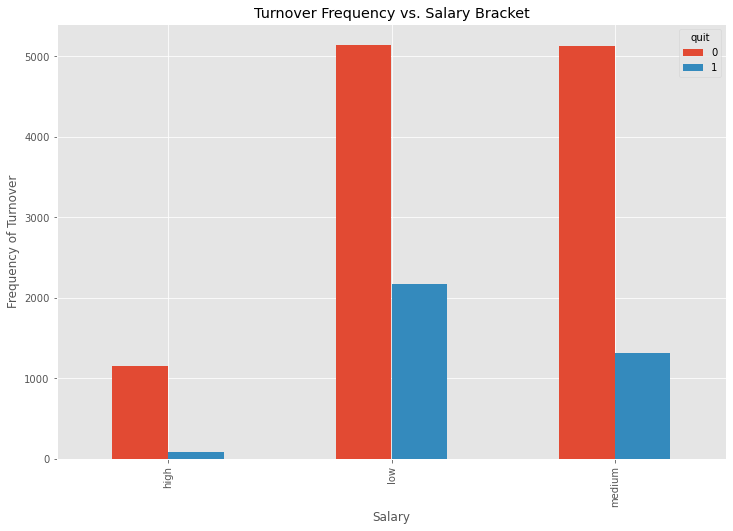

In [6]:
# Salary (low, medium, or high)
pd.crosstab(dataset.salary,dataset.quit).plot(kind='bar')
plt.title('Turnover Frequency vs. Salary Bracket')
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

We can see that employees with low salary quit more often, while those with a high salary quit less often.

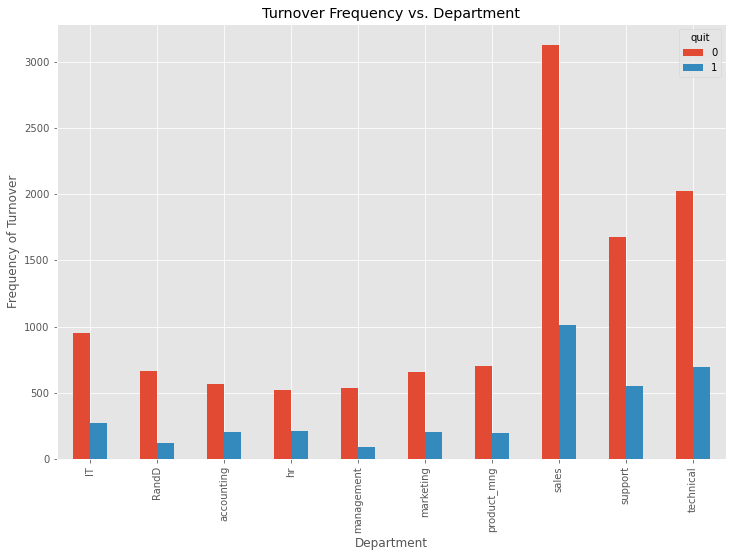

In [7]:
# Department
pd.crosstab(dataset.department,dataset.quit).plot(kind='bar')
plt.title('Turnover Frequency vs. Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

Here, we can visualize that employees in departments like 'sales' and 'technical' quit more frequently, while those in 'management' do so less frequently.

### Part 3: Encode Categorical Features
---

In this section, we convert all the categorical features into numerical indicators that a machine learning algorithm can better understand. For each value in a given feature, we create a column that indicates whether each instance contains that value (1) or not (0). Then, we remove the original column with the categorical values.

In [8]:
data = dataset.copy()
cat_vars = ['department','salary']
for var in cat_vars:
    cat_list = pd.get_dummies(data[var],prefix=var)
    data = data.join(cat_list)

In [9]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0


In [10]:
data.drop(columns=['department','salary'],axis=1,inplace=True)

### Part 4: Visualize Class Imbalance
---

In [12]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

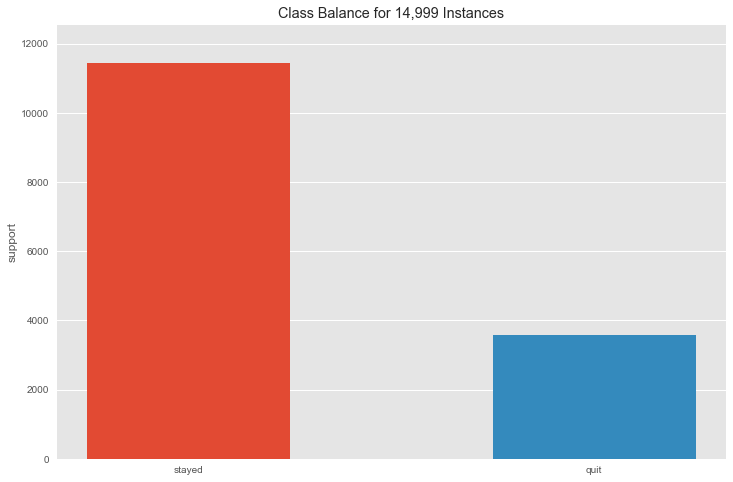

<AxesSubplot:title={'center':'Class Balance for 14,999 Instances'}, ylabel='support'>

In [13]:
visualizer = ClassBalance(labels=['stayed','quit']).fit(data.quit)
visualizer.show()

### Part 5: Create Training and Test Sets
---

In [14]:
X = data.loc[:,data.columns != 'quit']
Y = data.quit

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=0,test_size=0.2,stratify=Y)

### Parts 6 & 7: Build an Interactive Decision Tree Classifier
---

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [16]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [18]:
@interact
def plot_tree(crit=['gini','entropy'],
              split=['best','random'],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = DecisionTreeClassifier(random_state=0,
                                      criterion=crit,
                                      splitter=split,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf)
    estimator.fit(X_train,Y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(Y_train,estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(Y_test,estimator.predict(X_test))))
    
    graph = Source(tree.export_graphviz(estimator,out_file=None,
                                       feature_names=X_train.columns,
                                       class_names=['stayed','quit'],
                                       filled=True))
    #display(Image(data=graph.pipe(format='png')))
    
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Part 8: Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [19]:
@interact
def plot_tree_rf(crit=['gini','entropy'],
                 bootstrap=['True','False'],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = RandomForestClassifier(random_state=1,
                                      criterion=crit,
                                      bootstrap=bootstrap,
                                      n_estimators=forests,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf,
                                      n_jobs=-1,
                                      verbose=False).fit(X_train,Y_train)
    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(Y_train,estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(Y_test,estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('Visualizing Tree:',0)
    graph = Source(tree.export_graphviz(num_tree,out_file=None,
                                       feature_names=X_train.columns,
                                       class_names=['stayed','quit'],
                                       filled=True))
    #display(Image(data=graph.pipe(format='png')))
    
    return estimator
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Part 9: Feature Importance and Evaluation Metrics
---

In [20]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

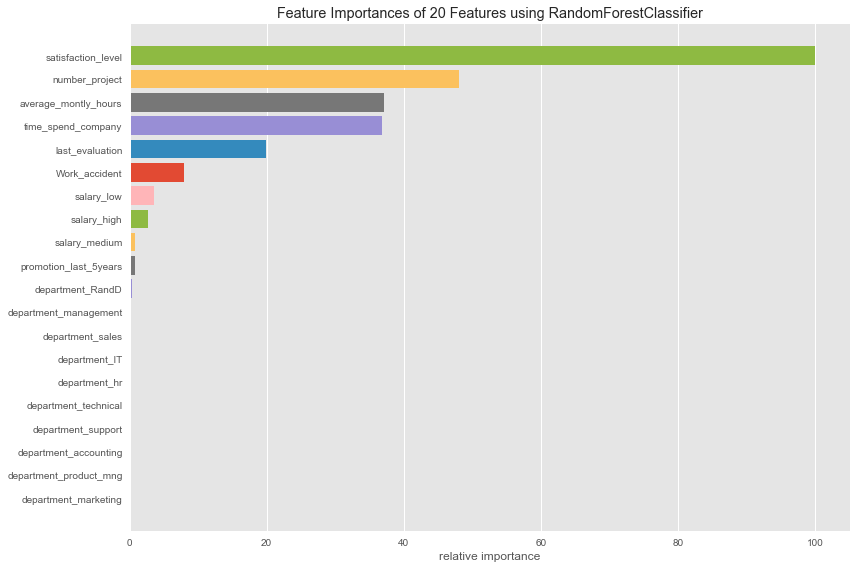

<AxesSubplot:title={'center':'Feature Importances of 20 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [25]:
rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)
viz = FeatureImportances(rf)
viz.fit(X_train,Y_train)
viz.show()

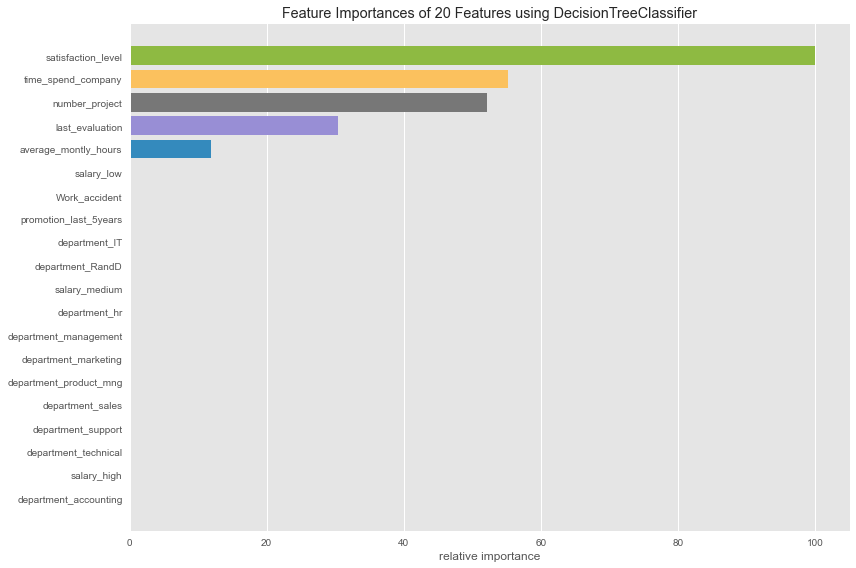

<AxesSubplot:title={'center':'Feature Importances of 20 Features using DecisionTreeClassifier'}, xlabel='relative importance'>

In [28]:
dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=0,
            splitter='best')
            
viz = FeatureImportances(dt)
viz.fit(X_train,Y_train)
viz.show()

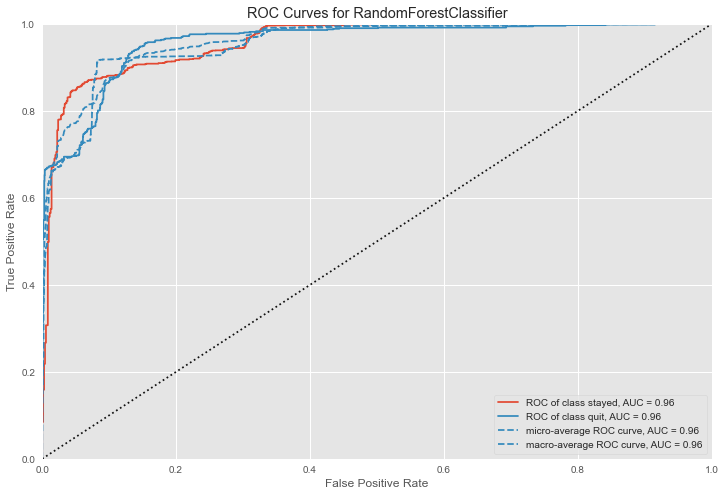

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [29]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=['stayed','quit'])
visualizer.fit(X_train,Y_train)
visualizer.score(X_test,Y_test)
visualizer.poof()

                                

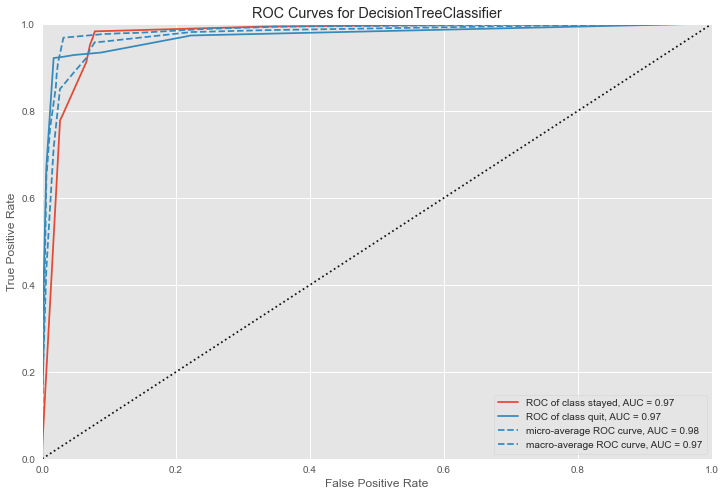

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [30]:
visualizer = ROCAUC(dt, classes=['stayed','quit'])
visualizer.fit(X_train,Y_train)
visualizer.score(X_test,Y_test)
visualizer.poof()